In [1]:
try:
    import relax
except ImportError:
    import sys; sys.path.append("..")

from relax import Trainer, TrainingConfig
from relax.models import VAE
from relax.utils import filter_params

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import jax
import optax
import haiku as hk
import numpy as np
import jax.numpy as jnp

import tensorflow_datasets as tfds

from dataclasses import dataclass
from typing import Tuple, Sequence, Optional

def ds_to_array(ds):
    itr = (
            ds
            .map(lambda d: d['image'] / 255)
            .as_numpy_iterator()
            )
    return jax.device_put(list(itr))

2022-10-23 23:00:04.174135: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 23:00:04.795416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu
2022-10-23 23:00:04.795516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu
2022-10-23 23:00:04.795523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, 

Let's import the dataset and turn it to a *jnp.ndarray*
---

In [2]:
train_ds, test_ds = tfds.load("mnist", split=["train[:80%]", "test"], batch_size=128)
x = ds_to_array(train_ds)
x_test = ds_to_array(test_ds)

Now we can declare the convolutional *Encoder* and *Decoder* 
---

In [3]:
@dataclass
class Encoder(hk.Module):
    latent_dim : int
    conv_dim : int = 32

    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = hk.Conv2D(self.conv_dim, kernel_shape=(3, 3), stride=2)(x)
        x = jax.nn.relu(x)
        x = hk.Conv2D(2*self.conv_dim, kernel_shape=(3, 3), stride=2)(x)
        x = jax.nn.relu(x)
        x = hk.Flatten()(x)

        μ = hk.Linear(self.latent_dim)(x)
        logvar = hk.Linear(self.latent_dim)(x)
        
        return μ, logvar

@dataclass
class Decoder(hk.Module):
    output_shape : Sequence[int]
    conv_dim : int = 32

    def __call__(self, z : jnp.ndarray) -> jnp.ndarray:
        
        w, h, _ = self.output_shape
        reshaped = (w//4, h//4, 32)
        z = hk.Linear(np.prod(reshaped))(z)
        z = jnp.reshape(z, (-1, *reshaped))

        z = hk.Conv2DTranspose(2*self.conv_dim, kernel_shape=(3, 3), stride=2)(z)
        z = jax.nn.relu(z)
        z = hk.Conv2DTranspose(self.conv_dim, kernel_shape=(3, 3), stride=2)(z)
        z = jax.nn.relu(z)
        logits = hk.Conv2DTranspose(1, kernel_shape=(3, 3), stride=1)(z)

        return logits

@hk.transform
def model(x):
    encoder=Encoder(latent_dim=10)
    decoder=Decoder(output_shape=(28, 28, 1))
    vae = VAE(
            encoder=encoder,
            decoder=decoder,
            )
    return vae(x)


@jax.jit
def loss_fn(params, rng, data) -> jnp.ndarray:
    logits, μ, logvar = model.apply(params, rng, data)
    bloss = VAE.loss_fn(logits, μ, logvar, data)
    return jnp.mean(bloss)

We can now setup the Trainer to run for *20* epochs with our *loss_fn*
---

In [4]:
config = TrainingConfig(
            epochs=25,
            )
optimizer = optax.adam(0.001)

trainer = Trainer(model, optimizer, config)

rng = jax.random.PRNGKey(42)
fake_input = jnp.zeros((1, 28, 28, 1))
init_state = trainer.init(rng, fake_input)

In [5]:
trained_state = trainer.train(init_state, loss_fn, x, jit_update_step=True)

Training:   0%|          | 0/25 [00:00<?, ?epoch/s]

Inference
---

Once trained, we can see how well the latent distribution *z* can be used to tweak the output on 2 dimensions

In [6]:
def encode(params, x, latent_dim=10):
    _, apply = hk.without_apply_rng(hk.transform(lambda x: Encoder(latent_dim=latent_dim)(x)))
    encoder_params = filter_params("encoder", params)
    return apply(encoder_params, x)

def decode(params, z, output_shape=(28, 28, 1)):
    _, apply = hk.without_apply_rng(hk.transform(lambda z: Decoder(output_shape=output_shape)(z)))
    decoder_params = filter_params("decoder", params)
    return apply(decoder_params, z)

In [7]:
def plot_latent_images(decode, params, rng, n, latent_shape, digit_size=28, dims=(0, 1)):
    """Plots n x n digit images decoded from the latent space."""
    from itertools import product
    from einops import rearrange
    import matplotlib.pyplot as plt
    
    def z_modified(x, dims, values):
        y = x
        for d, v in zip(dims, values):
            y = y.at[d].set(v)
        return y

    quant = jax.scipy.stats.norm.ppf(jnp.linspace(0.1, 0.9, n))
    z_ = jax.random.normal(rng, latent_shape)
    z = jnp.stack([z_modified(z_, dims, values) for values in product(quant, quant)])

    image = jax.nn.sigmoid(rearrange(decode(params, z), '(b1 b2) n1 n2 c -> (b1 n1) (b2 n2) c', b1=n))

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('Off')
    plt.show()
    return z

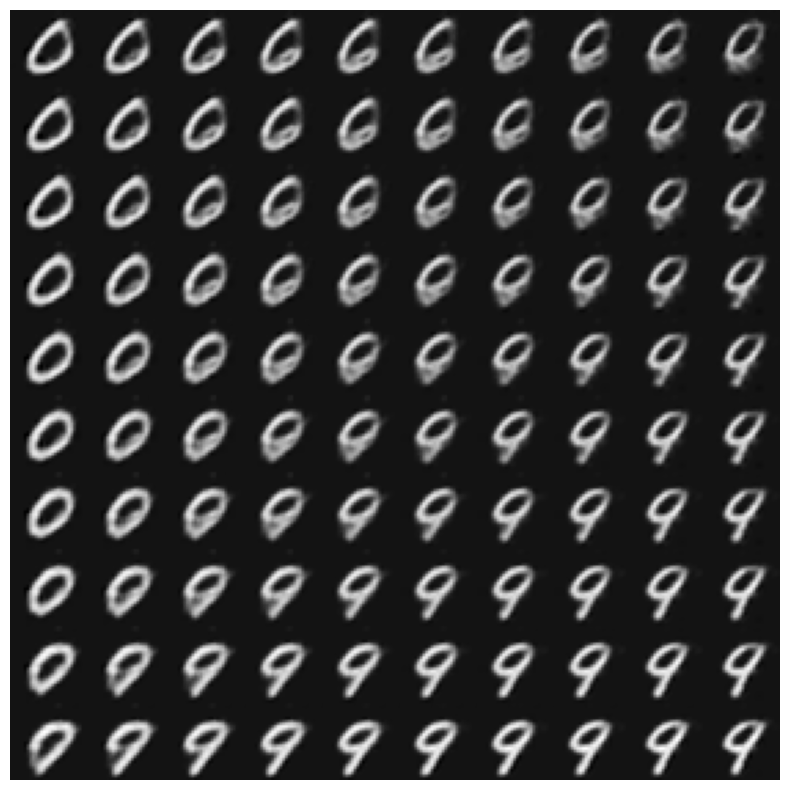

In [8]:
params = trained_state.params
rng = jax.random.PRNGKey(7)
dims = (7, 8)
n = 10
latent_shape = (10,)
z = plot_latent_images(decode, params, rng, n, latent_shape, dims=dims)